In [1]:
import os
from nipype.interfaces import fsl
from nipype.interfaces.io import SelectFiles, DataSink
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nipype.algorithms.modelgen as model
from config import root
from IPython.display import Image

fsl.FSLCommand.set_default_output_type("NIFTI_GZ")

In [2]:
def make_contrasts(contrasts, names, con_type="T", show_output=True):
    """Make contrasts as read into FSL"""

    contrasts_fmt = []
    for contrast in contrasts:

        # create contrast title
        title_left, title_right = [], []
        for k, v in contrast.items():
            title_left += [k] if v > 0 else []
            title_right += [k] if v < 0 else []
        title = ", ".join(title_left) + " > " + ", ".join(title_right)

        weights_per_regr = []
        for name in names:
            weight = contrast[name] if name in contrast.keys() else 0
            weights_per_regr.append(weight)

        contrasts_fmt.append((title, con_type, names, weights_per_regr))

    if show_output:
        for con in contrasts_fmt:
            print("="*20)
            print(con[0])
            print("-"*20)
            print(con[1])
            for reg, weight in zip(con[2], con[3]):
                print(reg, "\t", weight)
            print("="*20)
            print("\n")

    return contrasts_fmt


def localizer(in_file=''):

    from nipype.interfaces.base import Bunch
    import numpy as np

    times = np.loadtxt(in_file, delimiter='\t')

    # get all onsets and durations from array.
    # onsets are on odd rows, and offsets on even
    # rows.
    onsets = times[::2, :]
    durations = times[1::2, :] - times[::2, :]

    # for all localizer locations (those are four
    # different locations) create an event-file
    conditions = ['loc_' + str(i) for i in range(4)]
    onsets = [onsets[:, i] for i in range(4)]
    durations = [durations[:, i] for i in range(4)]

    return Bunch(conditions=conditions, onsets=onsets, durations=durations)

# Prepare

In [3]:
# pathnames
base_dir = os.path.join(root, "data")
output_dir = os.path.join(root, "data", "output")
working_dir = os.path.join(root, "data", "working_dir")

# MNI standard file
standard = os.path.join(root, "data", "in_analysis", "nii", "standard")
mni_standard_path = os.path.join(standard, "MNI152_T1_2mm_brain.nii.gz")
mni_brain_standard_path = os.path.join(standard, "MNI152_T1_2mm_brain.nii.gz")
mni_brain_mask_standard_path = os.path.join(standard, "MNI152_T1_2mm_brain_mask.nii.gz")

In [4]:
# Params
glm_prefix = "loc_"
TR = 2.1
filter_cutoff = 60

# Lists
sub_list = ["sub_%03d" % i for i in range(1, 7)]

## Input and output nodes

In [27]:
# iterate over subjects
infosource = pe.Node(
    util.IdentityInterface(
        fields=["sub_id"]),
    name="infosource")

# Define iterable attributes
infosource.iterables = [("sub_id", sub_list)]

# File templates for different subjects and sessions
templates = {
    "runs"       : "output/loc_highpass/ses_*{sub_id}/_loc_hp_filter*/run_*_st_mcf_warp_bet_smooth_hpf.nii.gz",    
    "behavior"   : "localizer/regs/dur_{sub_id}_ses_*_scn_*.txt",
    "func1"      : "output/loc_highpass/ses_000{sub_id}/_loc_hp_filter0/run_000_st_mcf_warp_bet_smooth_hpf.nii.gz",
    "warp_field" : "output/register_to_standard/{sub_id}/orig_field.nii.gz", 
    "premat"     : "output/register_to_standard/{sub_id}/inplane_brain_bbreg_{sub_id}.mat",
}

# SelectFiles Node to handle session specific file templates
files = pe.Node(
    SelectFiles(
        templates,
        base_directory=base_dir,
        sort_filelist=True),
    name="files")

# Create datasink to store important
# files in useful, more accessable locations.
datasink = pe.Node(
    DataSink(
        base_directory=base_dir,
        container="output"),
    name="datasink")

# Remove unwanted lengthy strings from filenames.
datasink.inputs.substitutions = [("_sub_id_", "")]

## Make contrasts

In [28]:
names = ['loc_' + str(i) for i in range(4)]
contrasts = [{'loc_0': 1,
                    'loc_1': -1.0/3,
                    'loc_2': -1.0/3,
                    'loc_3': -1.0/3},
                   {'loc_1': 1,
                    'loc_2': -1.0/3,
                    'loc_3': -1.0/3,
                    'loc_0': -1.0/3},
                   {'loc_2': 1,
                    'loc_3': -1.0/3,
                    'loc_0': -1.0/3,
                    'loc_1': -1.0/3},
                   {'loc_3': 1,
                    'loc_0': -1.0/3,
                    'loc_1': -1.0/3,
                    'loc_2': -1.0/3}]

contrasts_large = make_contrasts(contrasts, names)

loc_0 > loc_1, loc_2, loc_3
--------------------
T
loc_0 	 1
loc_1 	 -0.3333333333333333
loc_2 	 -0.3333333333333333
loc_3 	 -0.3333333333333333


loc_1 > loc_2, loc_3, loc_0
--------------------
T
loc_0 	 -0.3333333333333333
loc_1 	 1
loc_2 	 -0.3333333333333333
loc_3 	 -0.3333333333333333


loc_2 > loc_3, loc_0, loc_1
--------------------
T
loc_0 	 -0.3333333333333333
loc_1 	 -0.3333333333333333
loc_2 	 1
loc_3 	 -0.3333333333333333


loc_3 > loc_0, loc_1, loc_2
--------------------
T
loc_0 	 -0.3333333333333333
loc_1 	 -0.3333333333333333
loc_2 	 -0.3333333333333333
loc_3 	 1




## Setup GLM

In [29]:
glm_function = pe.MapNode(
    util.Function(
        input_names=["in_file"],
        output_names=["subject_info"],
        function=localizer),
    iterfield=["in_file"],
    name=glm_prefix+"glm_function")

# Specify model
specifymodel = pe.Node(
    model.SpecifyModel(
        high_pass_filter_cutoff=filter_cutoff,
        time_repetition=TR,
        input_units="secs",
    ), 
    name=glm_prefix+"specifymodel"
)

# Level 1 design
level1design = pe.Node(
    fsl.Level1Design(
        bases={"dgamma" : {"derivs": True}},
        interscan_interval=TR,
        model_serial_correlations=True, # Prewhitening
        contrasts=contrasts_large,
    ), 
    name=glm_prefix+"level1design"
)

# model
featmodel = pe.MapNode(
    interface=fsl.FEATModel(),
    name=glm_prefix+"featmodel_ses1",
    iterfield=["fsf_file", "ev_files"]
)

# FILMGLS
filmgls = pe.MapNode(
    interface=fsl.FILMGLS(
        threshold=50,
    ),
    iterfield=["design_file", "in_file", "tcon_file"],
    name=glm_prefix+"filmgls"
)

181001-22:22:37,220 workflow INFO:
	 Generated workflow graph: ./graph_hierarchical.png (graph2use=hierarchical, simple_form=True).


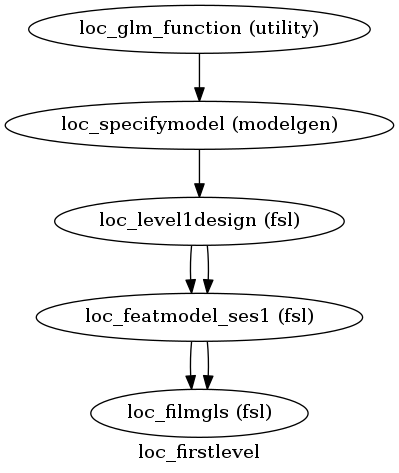

In [30]:
firstlevel = pe.Workflow(name=glm_prefix+"firstlevel", base_dir=working_dir)

firstlevel.connect(glm_function, "subject_info", specifymodel, "subject_info")
firstlevel.connect(specifymodel, "session_info", level1design, "session_info")
firstlevel.connect(level1design, "fsf_files", featmodel, "fsf_file")
firstlevel.connect(level1design, "ev_files", featmodel, "ev_files")
firstlevel.connect(featmodel, "design_file", filmgls, "design_file")
firstlevel.connect(featmodel, "con_file", filmgls, "tcon_file")

firstlevel.write_graph(simple_form=True, graph2use="hierarchical", dotfilename="./graph_hierarchical.dot")

# Visualize graph
Image(width=768, filename="graph_hierarchical.png")

## Second level

In [31]:
num_contrasts = len(contrasts)
con_list = ["%d" % (i+1) for i in range(num_contrasts)]

In [32]:
meanfunc = pe.Node(
    interface=fsl.ImageMaths(
        op_string="-Tmean",
        suffix="_mean"),
    name="meanfunc")

meanfuncmask = pe.Node(
    interface=fsl.BET(
        mask=True,
        no_output=True,
        frac=0.05),
    name="meanfuncmask")

dilatemask = pe.Node(
    interface=fsl.ImageMaths(
        suffix="_dil",
        op_string="-dilF"),
    name="dilatemask")

# Concatenate copes before feeding to Flameo
merge_copes = pe.MapNode(
    interface=fsl.Merge(
        dimension="t"),
    iterfield=["in_files"],
    name="merge_copes")

merge_varcopes = pe.MapNode(
    interface=fsl.Merge(
        dimension="t"),
    iterfield=["in_files"],
    name="merge_varcopes")

# Create a level2 model
l2model_fixed = pe.Node(
    interface=fsl.L2Model(), 
    name="l2model_fixed")

# A fixed effects FLAMEO node, with copes and varcopes as inputs.
fixed_flameo = pe.MapNode(
    interface=fsl.FLAMEO(
        run_mode="fe"),
    iterfield=["cope_file", "var_cope_file"],
    name="fixed_flameo")

applywarp_copes = pe.MapNode(
    fsl.ApplyWarp(
        ref_file=mni_standard_path),
    iterfield=["in_file"],
    name="applywarp_copes",
    overwrite=False)

applywarp_varcopes = pe.MapNode(
    fsl.ApplyWarp(
        ref_file=mni_standard_path),
    iterfield=["in_file"],
    name="applywarp_varcopes",
    overwrite=False)

applywarp_zstats = pe.MapNode(
    fsl.ApplyWarp(
        ref_file=mni_standard_path),
    iterfield=['in_file'],
    name='applywarp_zstats',
    overwrite=False)

181001-22:22:39,68 workflow INFO:
	 Generated workflow graph: ./graph_hierarchical.png (graph2use=hierarchical, simple_form=True).


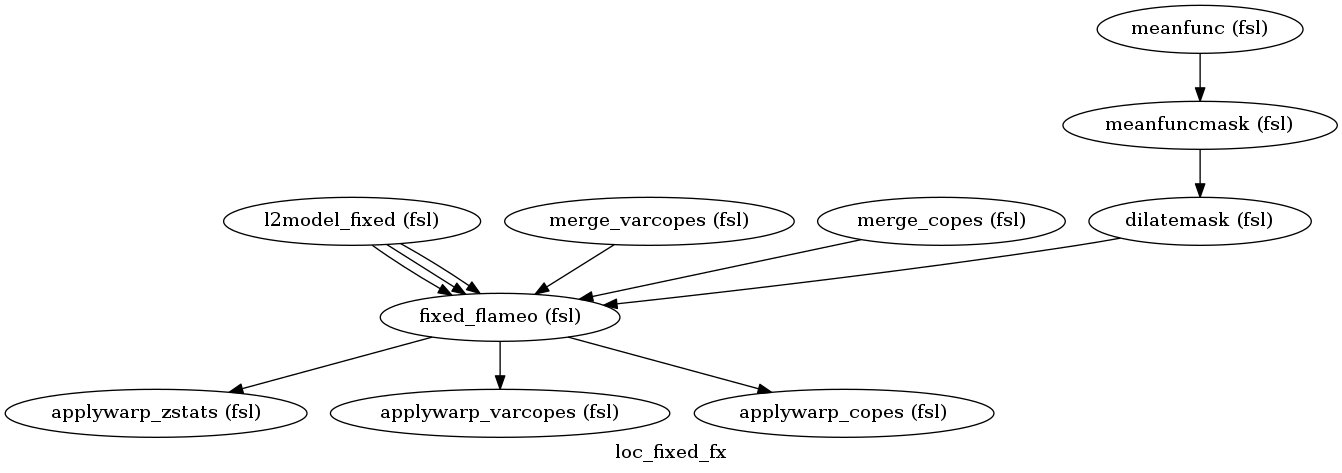

In [33]:
fixed_fx = pe.Workflow(name=glm_prefix+"fixed_fx", base_dir=working_dir)

def num_copes(files):
    return len(files)

fixed_fx.connect(meanfunc, "out_file", meanfuncmask, "in_file")
fixed_fx.connect(meanfuncmask, "mask_file", dilatemask, "in_file")
fixed_fx.connect(dilatemask, "out_file", fixed_flameo, "mask_file")
fixed_fx.connect(merge_copes, "merged_file", fixed_flameo, "cope_file")
fixed_fx.connect(merge_varcopes, "merged_file", fixed_flameo, "var_cope_file")
fixed_fx.connect(l2model_fixed, "design_mat", fixed_flameo, "design_file")
fixed_fx.connect(l2model_fixed, "design_con", fixed_flameo, "t_con_file")
fixed_fx.connect(l2model_fixed, "design_grp", fixed_flameo, "cov_split_file")
fixed_fx.connect(fixed_flameo, "copes", applywarp_copes, "in_file")
fixed_fx.connect(fixed_flameo, "var_copes", applywarp_varcopes, "in_file")
fixed_fx.connect(fixed_flameo, "zstats", applywarp_zstats, "in_file")

fixed_fx.write_graph(simple_form=True, graph2use="hierarchical", dotfilename="./graph_hierarchical.dot")
Image(width=768, filename="graph_hierarchical.png")

181001-22:22:39,981 workflow INFO:
	 Generated workflow graph: ./graph_hierarchical.png (graph2use=hierarchical, simple_form=True).


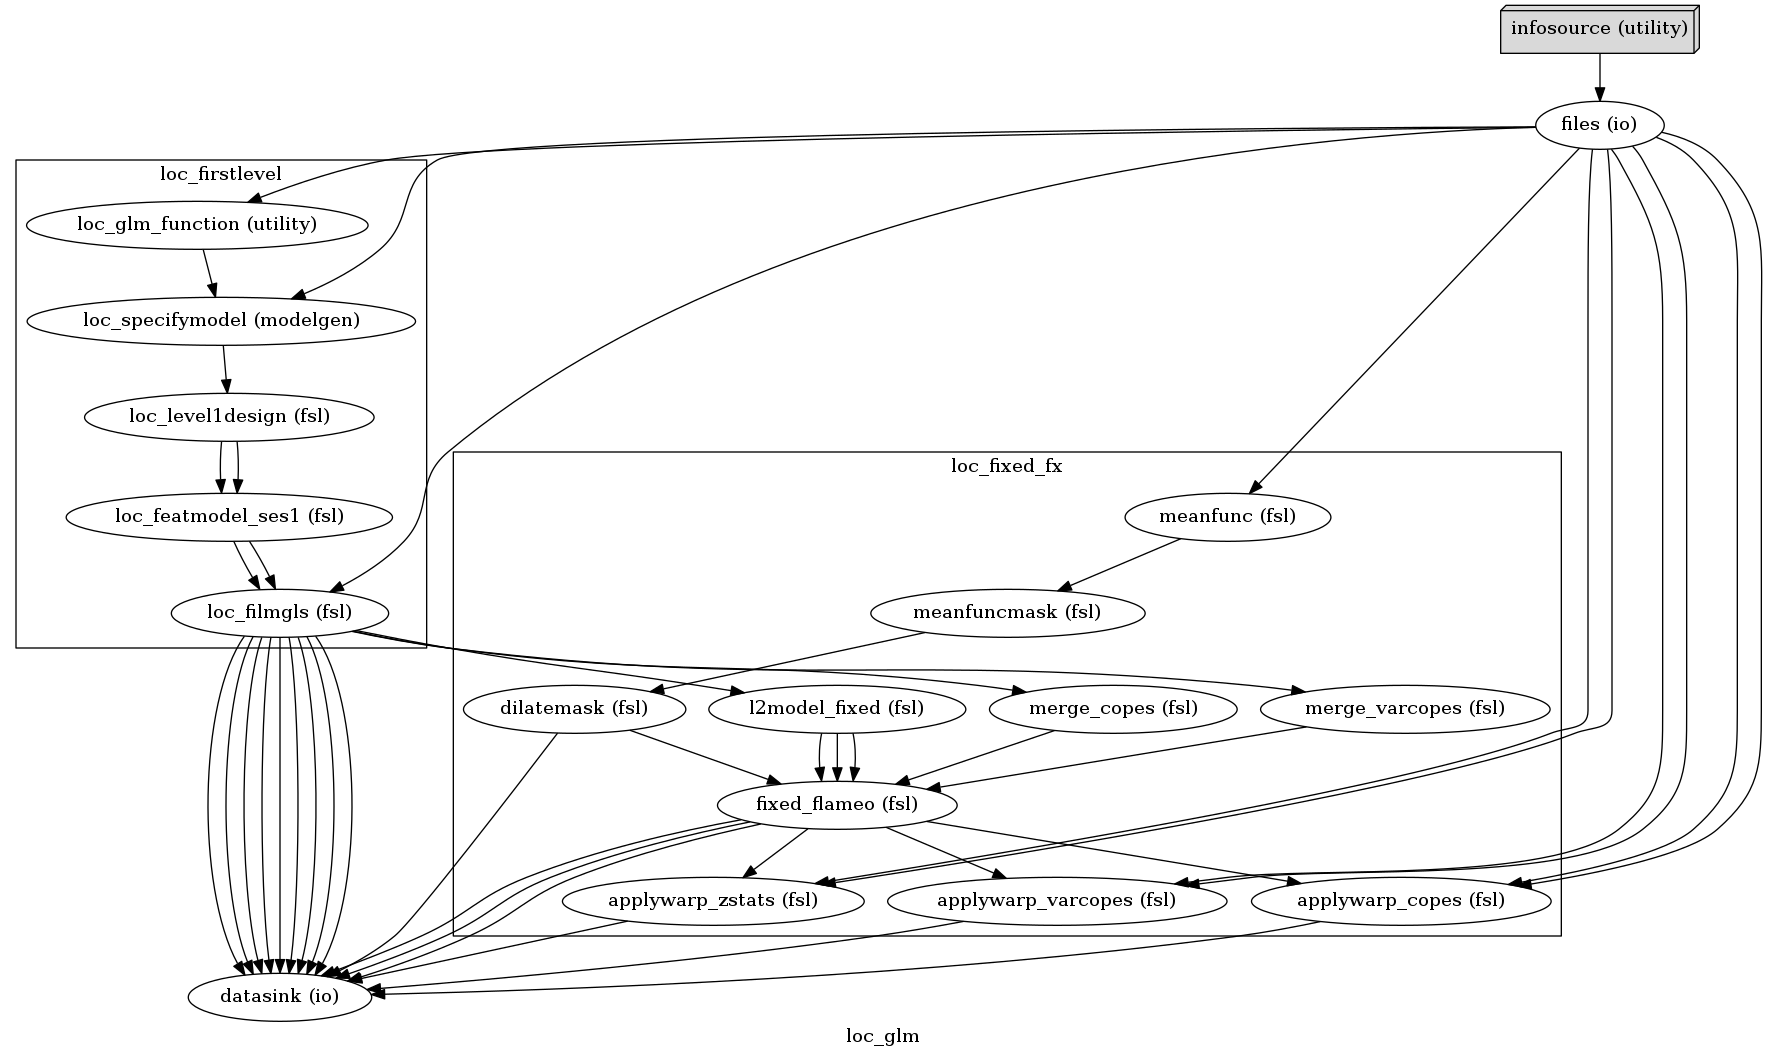

In [34]:
glm = pe.Workflow(name="loc_glm", base_dir=working_dir)

# Inputs first level
glm.connect(files, "behavior", firstlevel, glm_prefix+"glm_function.in_file")
glm.connect(files, "runs", firstlevel, glm_prefix+"specifymodel.functional_runs")
glm.connect(files, "runs", firstlevel, glm_prefix+"filmgls.in_file")
glm.connect(files, "func1", fixed_fx, "meanfunc.in_file")

# Inputs warp
glm.connect(infosource, "sub_id", files, "sub_id")
glm.connect(files, "premat", fixed_fx, "applywarp_copes.premat")
glm.connect(files, "warp_field", fixed_fx, "applywarp_copes.field_file")
glm.connect(files, "premat", fixed_fx, "applywarp_varcopes.premat")
glm.connect(files, "warp_field", fixed_fx, "applywarp_varcopes.field_file")
glm.connect(files, "premat", fixed_fx, "applywarp_zstats.premat")
glm.connect(files, "warp_field", fixed_fx, "applywarp_zstats.field_file")

def sort_copes(files):
    numelements = len(files[0])
    outfiles = []
    for i in range(numelements):
        outfiles.insert(i,[])
        for j, elements in enumerate(files):
            outfiles[i].append(elements[i])
    return outfiles

def num_copes(files):
    return len(files)

# Connect first to second level
glm.connect(firstlevel, (glm_prefix+"filmgls.copes", sort_copes), fixed_fx, "merge_copes.in_files")
glm.connect(firstlevel, (glm_prefix+"filmgls.varcopes", sort_copes), fixed_fx, "merge_varcopes.in_files")
glm.connect(firstlevel, (glm_prefix+"filmgls.copes", num_copes), fixed_fx, "l2model_fixed.num_copes")

# Outputs Level 1
glm.connect(firstlevel, glm_prefix+"filmgls.zstats", datasink, glm_prefix+"filmgls.@zstats")
glm.connect(firstlevel, glm_prefix+"filmgls.param_estimates", datasink, glm_prefix+"filmgls.@param_estimates")
glm.connect(firstlevel, glm_prefix+"filmgls.copes", datasink, glm_prefix+"filmgls.@copes")
glm.connect(firstlevel, glm_prefix+"filmgls.varcopes", datasink, glm_prefix+"filmgls.@varcopes")
glm.connect(firstlevel, glm_prefix+"filmgls.dof_file", datasink, glm_prefix+"filmgls.@dof_file")
glm.connect(firstlevel, glm_prefix+"filmgls.logfile", datasink, glm_prefix+"filmgls.@logfile")
glm.connect(firstlevel, glm_prefix+"filmgls.residual4d", datasink, glm_prefix+"filmgls.@residual4d")
glm.connect(firstlevel, glm_prefix+"filmgls.sigmasquareds", datasink, glm_prefix+"filmgls.@sigmasquareds")
glm.connect(firstlevel, glm_prefix+"filmgls.tstats", datasink, glm_prefix+"filmgls.@tstats")

# Outputs Level 2
glm.connect(fixed_fx, "dilatemask.out_file", datasink, glm_prefix + "L2_fixedfx"+".funcmask")
glm.connect(fixed_fx, "fixed_flameo.copes", datasink, glm_prefix + "L2_fixedfx"+".copes")
glm.connect(fixed_fx, "fixed_flameo.var_copes", datasink, glm_prefix + "L2_fixedfx"+".varcopes")
glm.connect(fixed_fx, "fixed_flameo.zstats", datasink, glm_prefix + "L2_fixedfx"+".zstats")
glm.connect(fixed_fx, "applywarp_copes.out_file", datasink, glm_prefix + "L2_fixedfx"+"_warped"+".copes")
glm.connect(fixed_fx, "applywarp_varcopes.out_file", datasink, glm_prefix + "L2_fixedfx"+"_warped"+".varcopes")
glm.connect(fixed_fx, "applywarp_zstats.out_file", datasink, glm_prefix + "L2_fixedfx"+"_warped"+".zstats")

glm.write_graph(
    simple_form=True, 
    graph2use="hierarchical", 
    dotfilename="./graph_hierarchical.dot"
)

Image(width=768, filename="graph_hierarchical.png")

In [ ]:
glm.run(plugin='MultiProc')